In [1]:
%matplotlib notebook

In [2]:
import csv
import numpy as np
import pandas as pd
import math
import time


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Read data

In [5]:
filename = "akash_home_walk_1.txt"

In [253]:
def GetData(filename):
    with open(filename) as f:
        lines = f.readlines()
    
    frame_num_count = -1
    frame_num = []
    x = []
    y = []
    z = []
    velocity = []
    intensity = []
    depth = []
    
    # Offset
    x_off = 0
    y_off = 4
    z_off = 8
    velocity_off = 24
    intensity_off = 16
    depth_off = 20
    point_step = 32
    
    for line in lines:
        # Find where data frames are
        if line[:5] == 'data:':
            frame_num_count += 1
            frame_data = line[7:-2].split(",")
            frame_data = np.asarray(frame_data)
            frame_data = frame_data.astype(np.uint8)
            
            init_pt1 = 0
            init_pt2 = point_step
            # Look at each point in the frame
            while init_pt2 <= len(frame_data):
                pt = frame_data[init_pt1:init_pt2]
                # Convert uint8 to float32
                x.append(float(pt[x_off:x_off+4].view('<f4')))
                y.append(float(pt[y_off:y_off+4].view('<f4')))
                z.append(float(pt[z_off:z_off+4].view('<f4')))
                velocity.append(float(pt[velocity_off:velocity_off+4].view('<f4')))
                intensity.append(float(pt[intensity_off:intensity_off+4].view('<f4')))
                depth.append(float(pt[depth_off:depth_off+4].view('<f4')))
                frame_num.append(frame_num_count)
                
                init_pt1 += point_step
                init_pt2 += point_step
    
    frame_num = np.asarray(frame_num)
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    velocity = np.asarray(velocity)
    intensity = np.asarray(intensity)

    data = pd.DataFrame()
    data['frame_num'] = frame_num.astype(np.int)
    data['x'] = x.astype(np.float)
    data['y'] = y.astype(np.float)
    data['z'] = z.astype(np.float)
    data['velocity'] = velocity.astype(np.float)
    data['intensity'] = intensity.astype(np.float)
    
    return data

In [30]:
data = GetData(filename)

In [31]:
data

frame_num         x         y         z  velocity  intensity
0              0  0.529297  0.287109  0.107422  0.000000  28.802418
1              0  0.566406  0.306641  0.111328  0.000000  30.413927
2              0  0.601562  0.328125  0.132812  0.000000  27.528164
3              0  0.537109  0.509766  0.050781  0.000000  22.504200
4              0  0.554688  0.515625  0.208984  0.000000  23.201464
...          ...       ...       ...       ...       ...        ...
53446        997  2.546875 -0.353516 -1.197266  0.750914   9.542425
53447        997  2.482422 -0.089844 -1.455078  0.750914  12.552725
53448        997  3.044922  0.095703  0.214844  0.750914  12.304489
53449        997  3.080078 -0.000000  0.316406  0.750914  11.760913
53450        997  3.125000 -0.197266  0.238281  0.750914  13.802113

[53451 rows x 6 columns]

In [32]:
data.describe()

frame_num             x             y             z      velocity  \
count  53451.000000  53451.000000  53451.000000  53451.000000  53451.000000   
mean     496.746104      2.185586      0.068856     -0.193606      0.169431   
std      288.000754      1.469322      0.908423      0.552115      0.330212   
min        0.000000      0.001953     -4.816406     -4.794922     -1.752133   
25%      247.000000      0.994141     -0.109375     -0.537109      0.000000   
50%      497.000000      2.179688      0.169922     -0.246094      0.250305   
75%      745.500000      2.964844      0.564453      0.062500      0.250305   
max      997.000000      4.972656      4.775391      4.734375      1.752133   

          intensity  
count  53451.000000  
mean      17.519895  
std        5.204398  
min        3.010300  
25%       13.617278  
50%       17.853298  
75%       20.969101  
max       32.552727

# Small tool functions

In [54]:
def Normalize(x, x_min, x_max):
    return (x-x_min)/(x_max-x_min)

In [236]:
# Normalize a list of intensity to [0,1] as weights
from sklearn.preprocessing import MinMaxScaler
def Weight(datalist):
    return MinMaxScaler().fit_transform(np.asarray(datalist.intensity).reshape(-1,1)).reshape(1,-1)[0]

In [301]:
# Reshape numpy arrays
def HorToVer(array):
    return array.reshape(-1,1)
def VerToHor(array):
    return array.reshape(1,-1)

In [766]:
# Angle between two vectors (0-1, 0=vertical, 1=same direction)
def VectorAngle(vec1, vec2):
    return np.abs(np.dot(vec1, vec2))/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

# Plot data points

In [254]:
def GetColors(label_list):
    color_list = ['r', 'b', 'g', 'c', 'm', 'darkorange', 'deepskyblue', 'blueviolet', 'crimson', 'orangered', 'k']
    return list(map(lambda x: color_list[x], label_list))


In [255]:
# alpha = 'none', 'intensity', 'velocity'
def PlotData(ax, datalist, **kwargs):
    datalist = datalist.reset_index()

    if 'color' not in kwargs.keys():
        kwargs['color'] = ['k']*len(datalist)
    elif len(kwargs['color']) != len(datalist):
        kwargs['color'] = list(kwargs['color'])*len(datalist)

    if 'alpha' in kwargs.keys() and kwargs['alpha'] in ['intensity', 'velocity']:
        weight_min = np.min(np.abs(datalist[kwargs['alpha']]))
        weight_max = np.max(np.abs(datalist[kwargs['alpha']]))
    
        for i in range(len(datalist)):
            ax.scatter(datalist.x[i], datalist.y[i], datalist.z[i], color = kwargs['color'][i], alpha = Normalize(datalist.loc[i][kwargs['alpha']], weight_min, weight_max), marker = '.')
    else:
        for i in range(len(datalist)):
            ax.scatter(datalist.x[i], datalist.y[i], datalist.z[i], color = kwargs['color'][i], marker = '.')


In [488]:
# Plot settings
def PlotSetting(ax):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # ax.set_xlim(-1, 5)
    # ax.set_ylim(-1, 2)
    # ax.set_zlim(-0.5, 1.5)

# Choose frame window

In [49]:
# How many data points in each frame
frame_point_count = []
for i in range(np.max(data.frame_num)+1):
    frame_point_count.append(len(data[data.frame_num==i]))

pd.Series(frame_point_count).describe()

count    998.000000
mean      53.558116
std        1.525487
min       47.000000
25%       53.000000
50%       54.000000
75%       54.000000
max       59.000000
dtype: float64

In [83]:
# How many data points in each 5-frame window
frame_point_count = []
WINDOW = 5
for i in range(int(np.max(data.frame_num)/WINDOW)):
    frame_point_count.append(len(data[(data.frame_num>=i*WINDOW)&(data.frame_num<(i+1)*WINDOW)]))

pd.Series(frame_point_count).describe()

count    199.000000
mean     267.804020
std        5.223953
min      243.000000
25%      265.500000
50%      269.000000
75%      270.000000
max      289.000000
dtype: float64

<IPython.core.display.Javascript object>


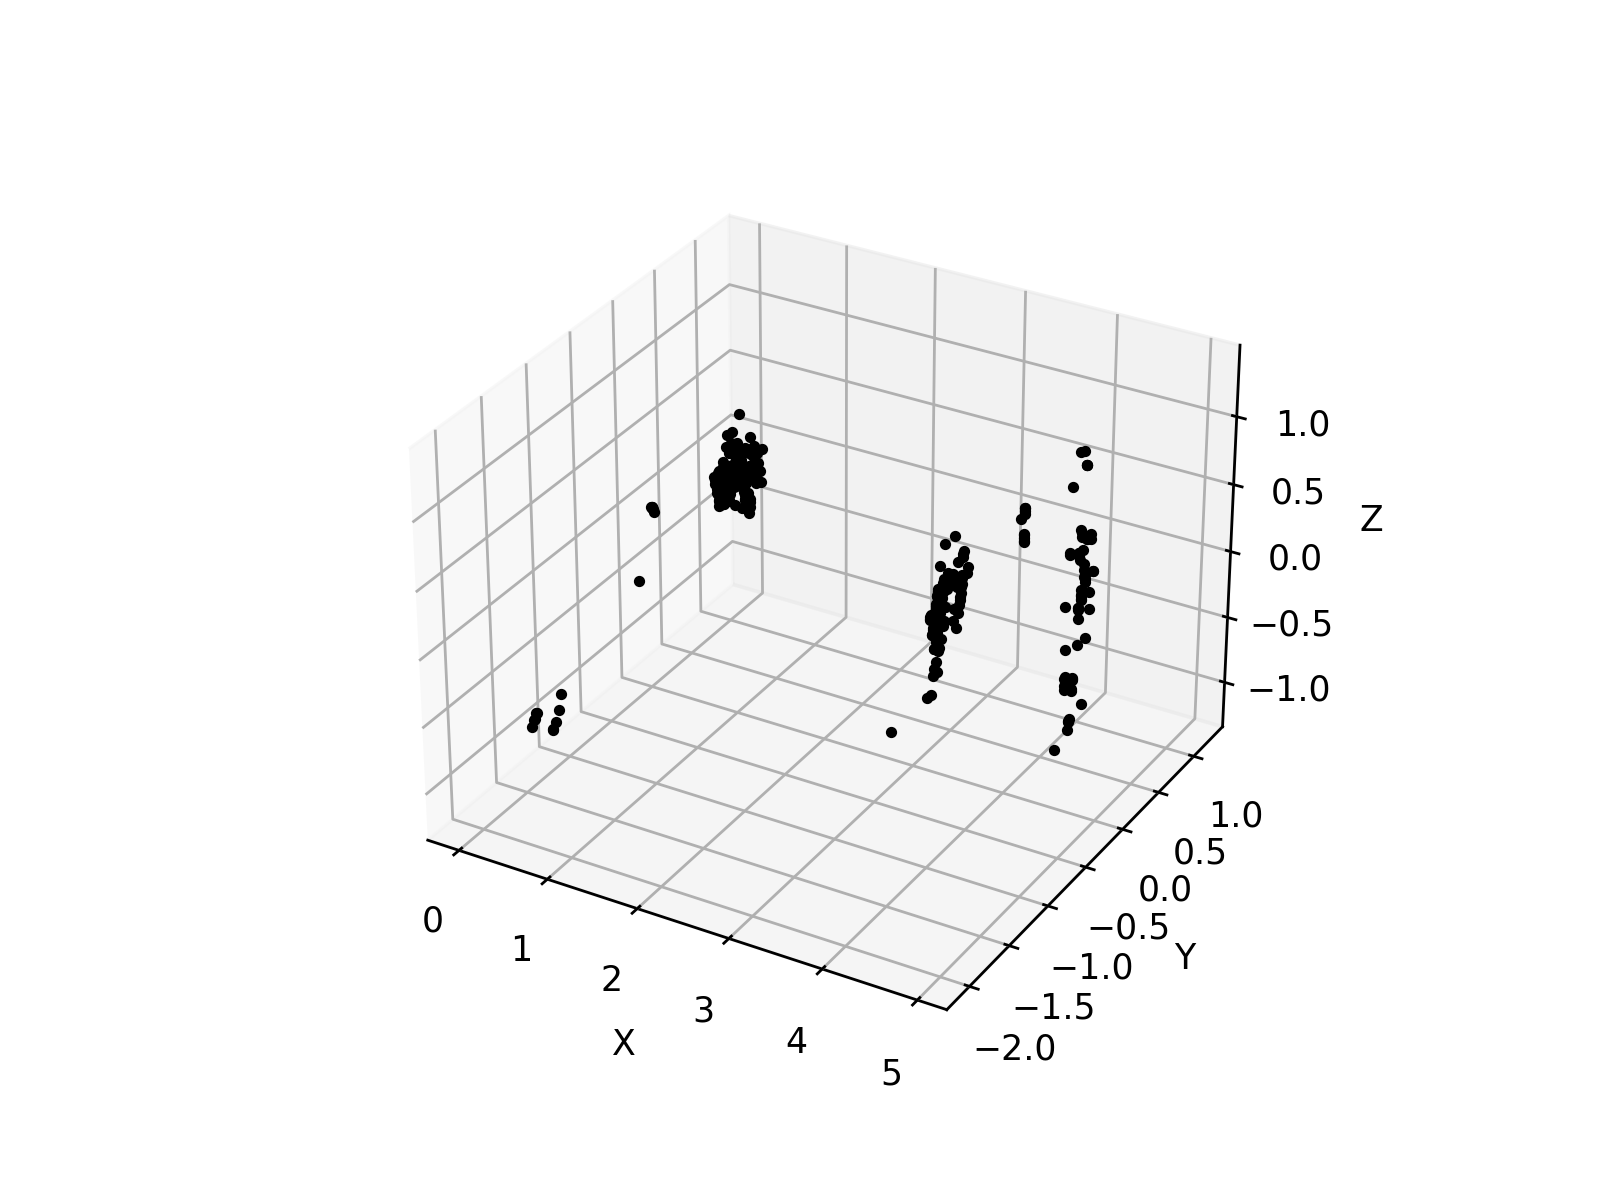

In [489]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

PlotData(ax, data[data.frame_num<5])

plt.show()

# DBSCAN clustering

In [165]:
from sklearn.cluster import DBSCAN

In [260]:
def ModelCluster(datalist, model, sample_weight=False, show_plot=True, return_cluster=False):
    if sample_weight:
        sample_weight = Weight(datalist)
    else:
        sample_weight = None
    clustering = model.fit(np.asarray(datalist.iloc[:,1:4]), sample_weight = sample_weight)
    
    if show_plot:
        fig = plt.figure()
        ax = fig.gca(projection = '3d')
        PlotSetting(ax)
        
        PlotData(ax, datalist, color = GetColors(clustering.labels_))
        
        plt.show()
    
    if return_cluster:
        return clustering

## Compare with and without sample_weight

<IPython.core.display.Javascript object>


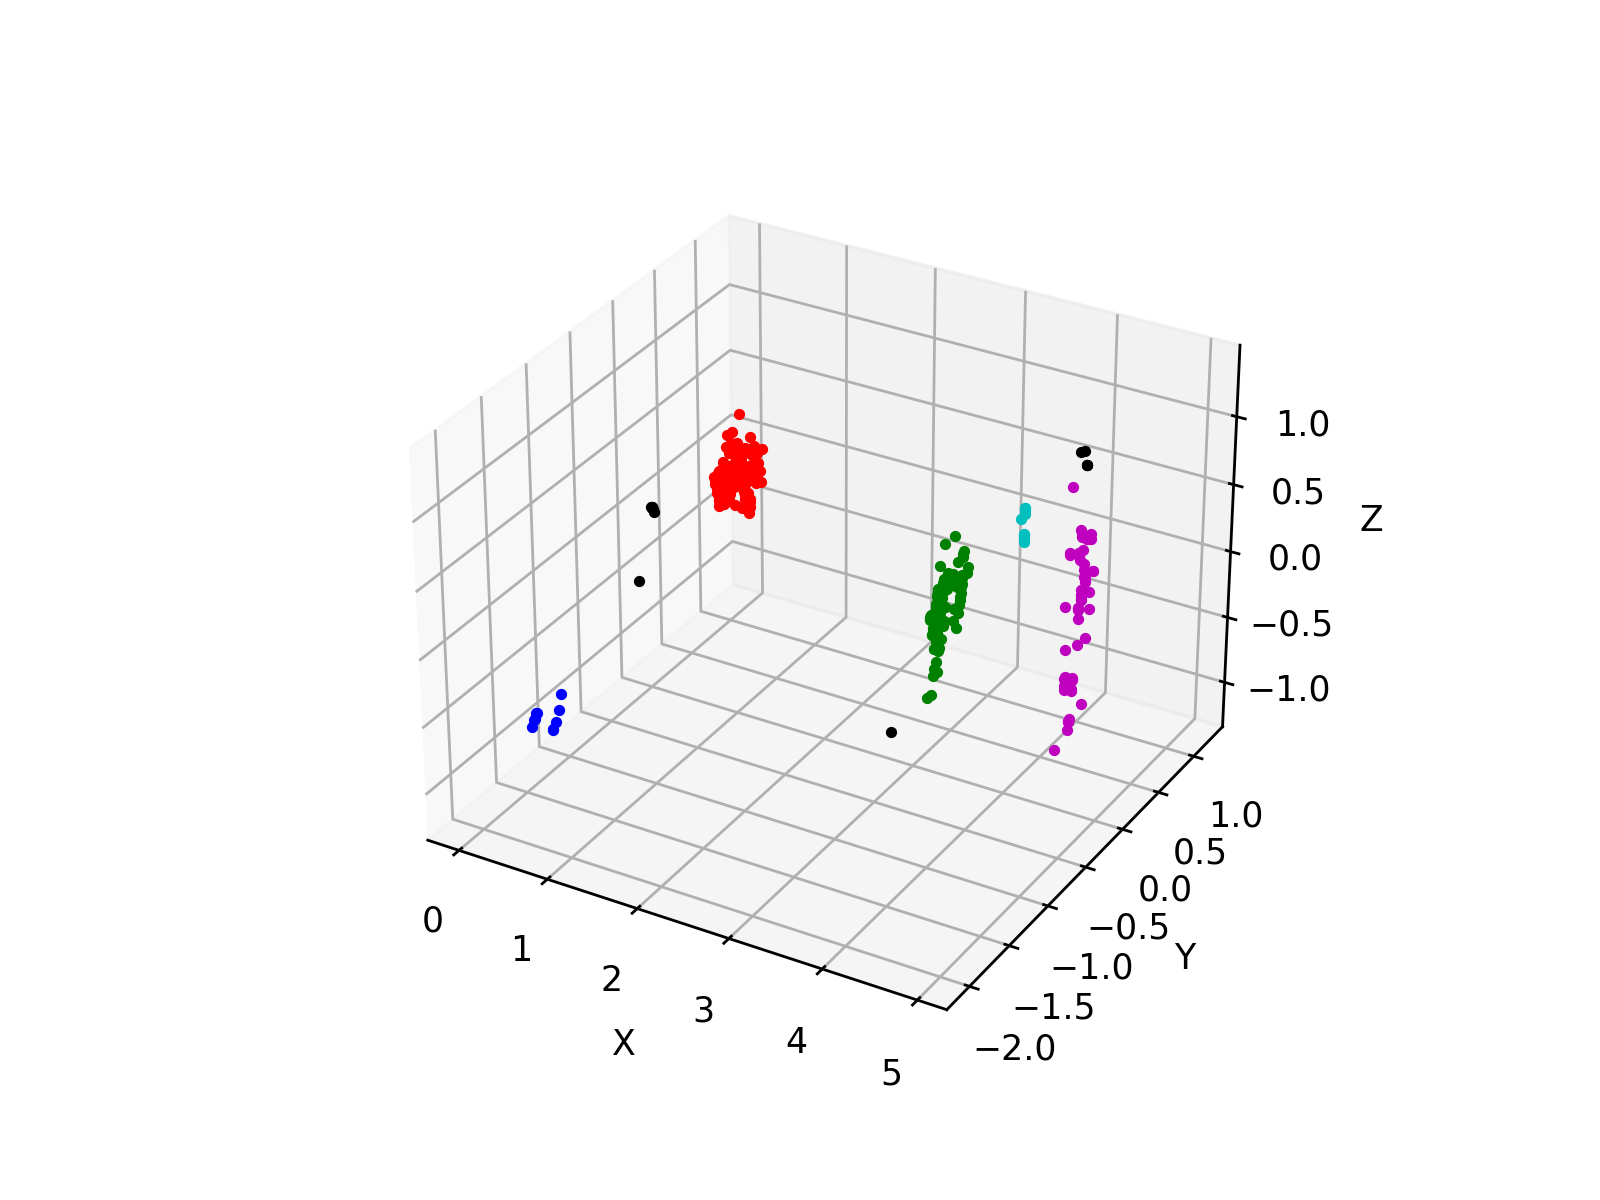

<IPython.core.display.Javascript object>


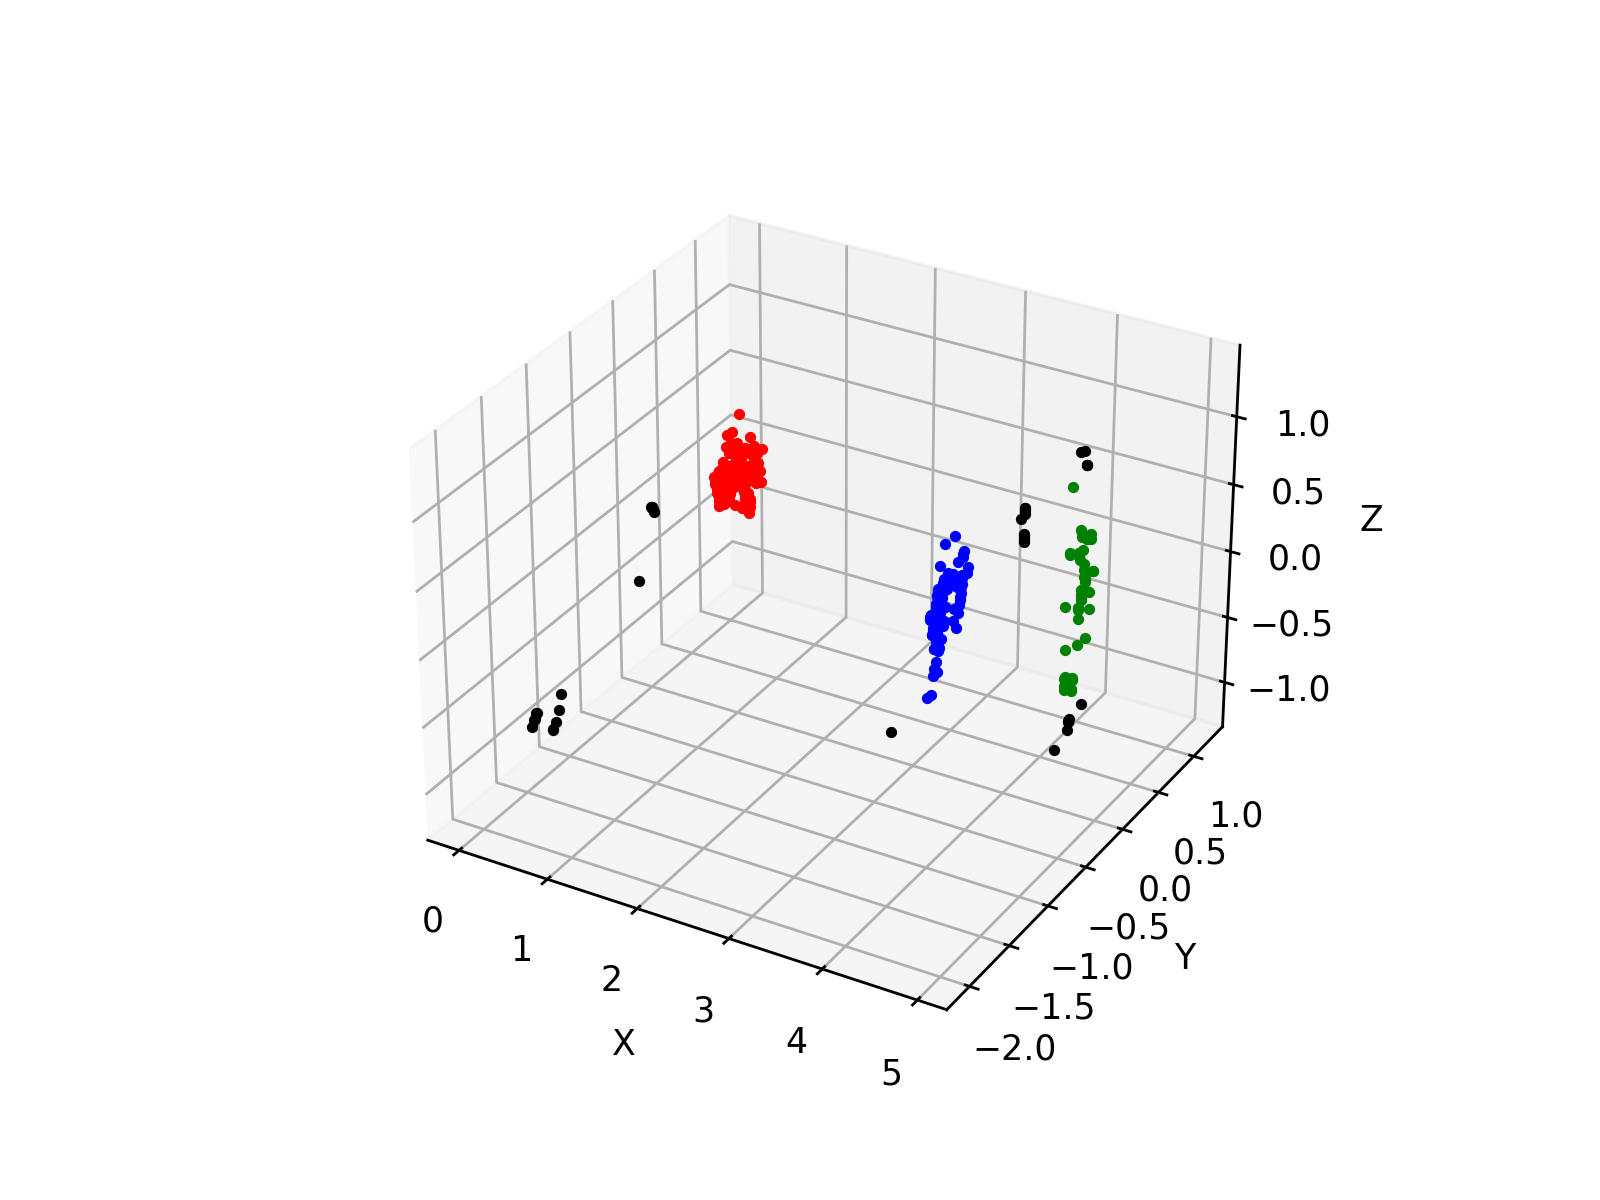

In [261]:
# Clustering frame_num = 0~4
startFrame = 0
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

ModelCluster(datalist, dbscan)
ModelCluster(datalist, dbscan, sample_weight=True)

<IPython.core.display.Javascript object>


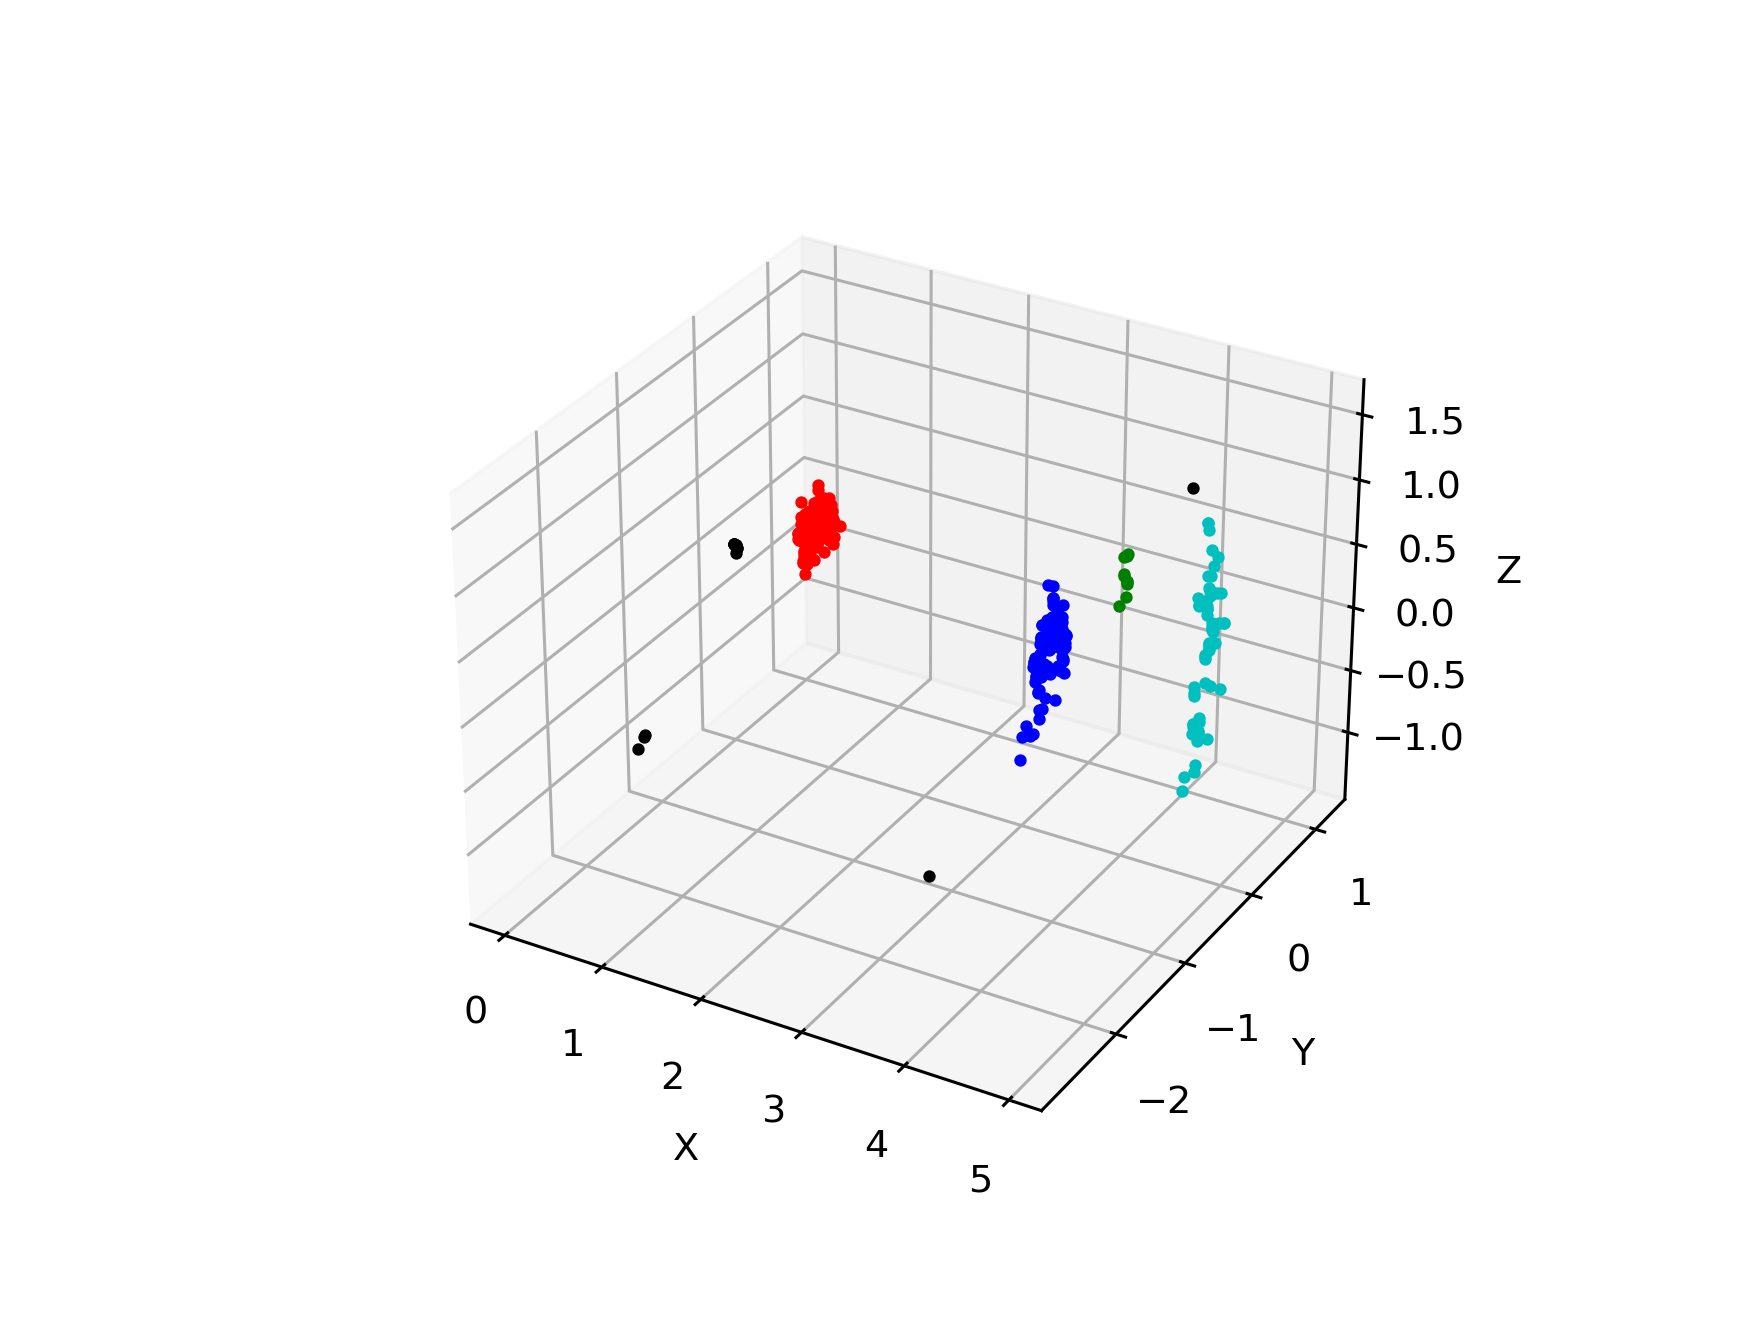

<IPython.core.display.Javascript object>


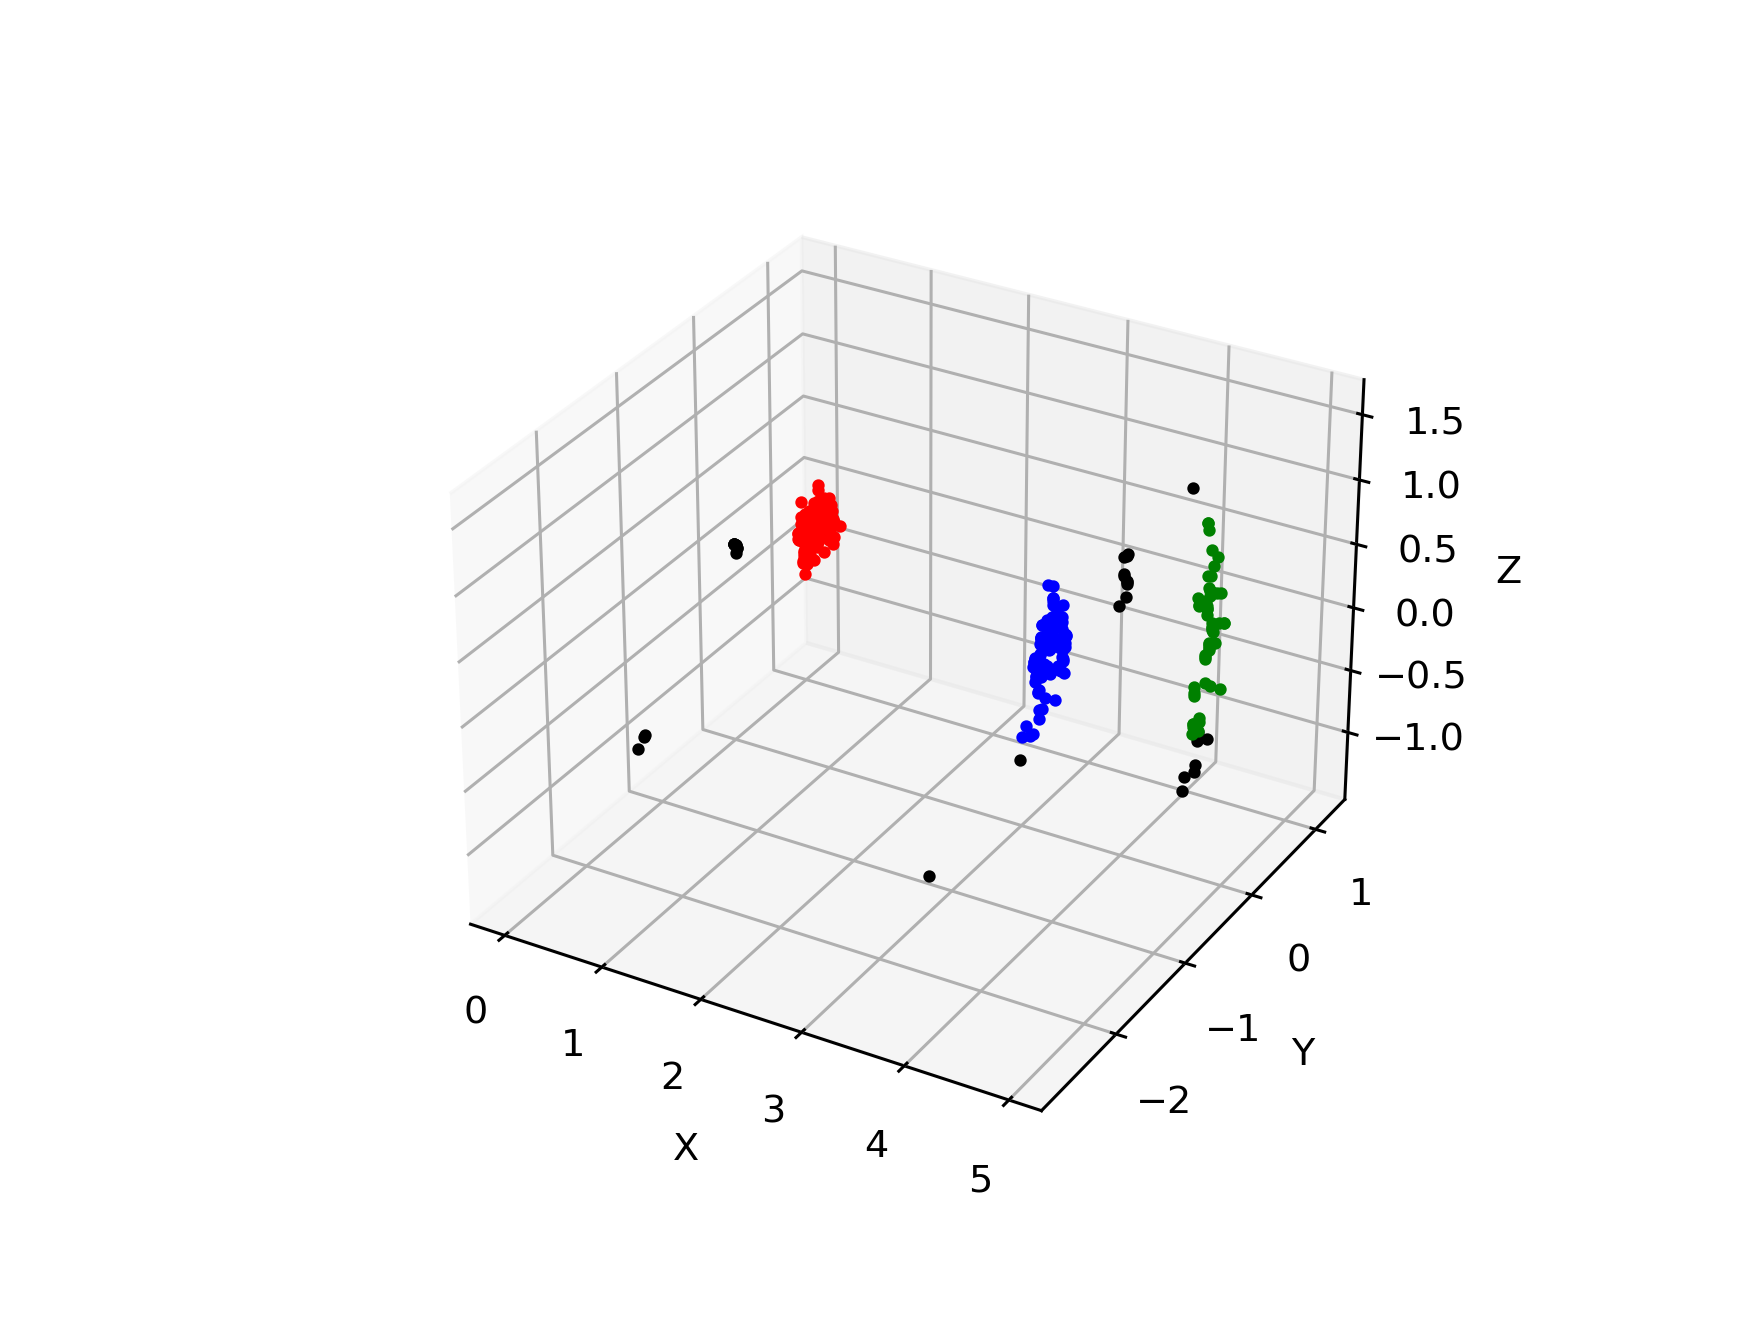

In [203]:
# Clustering frame_num = 5~9
startFrame = 5
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

ModelCluster(datalist, dbscan)
ModelCluster(datalist, dbscan, sample_weight=True)

<IPython.core.display.Javascript object>


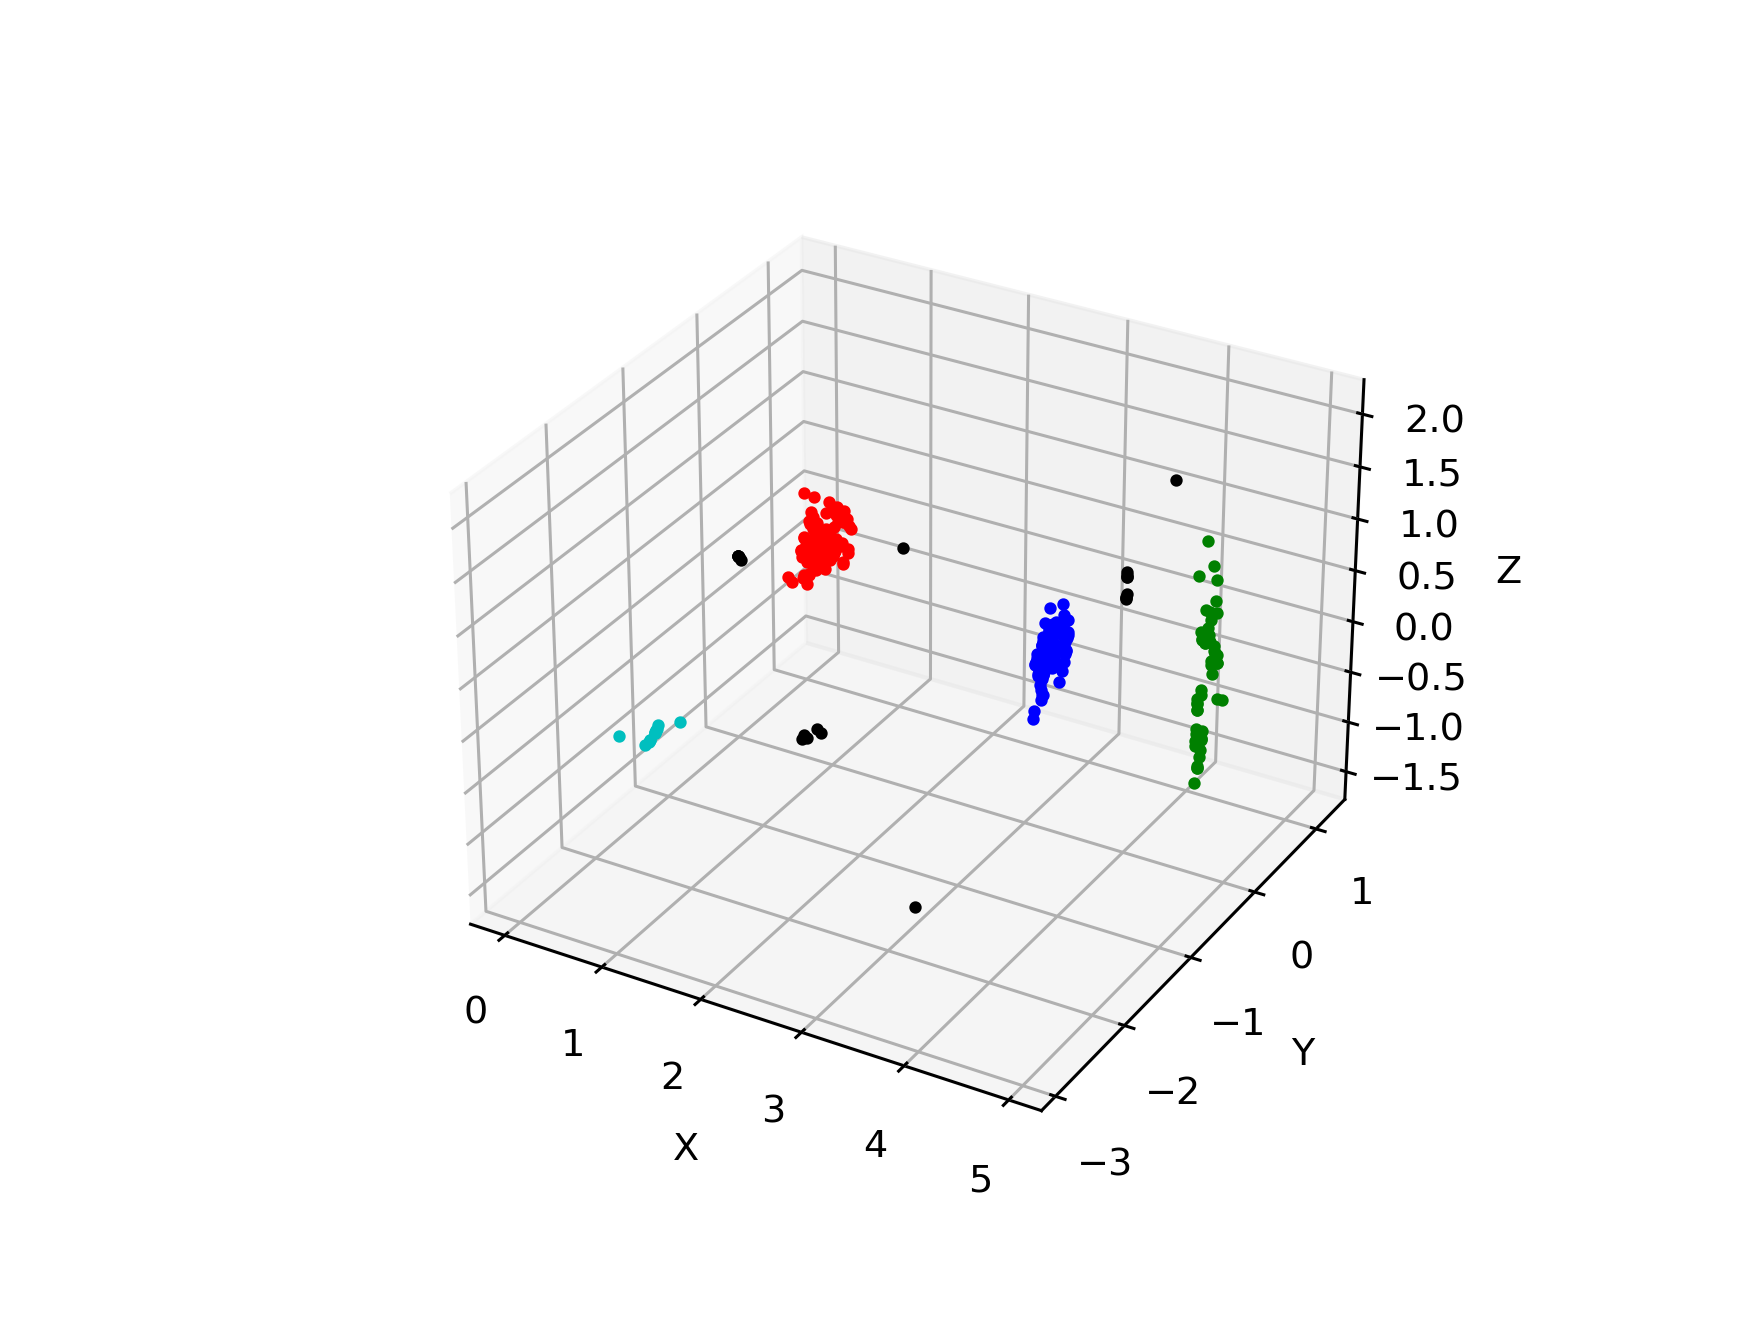

<IPython.core.display.Javascript object>


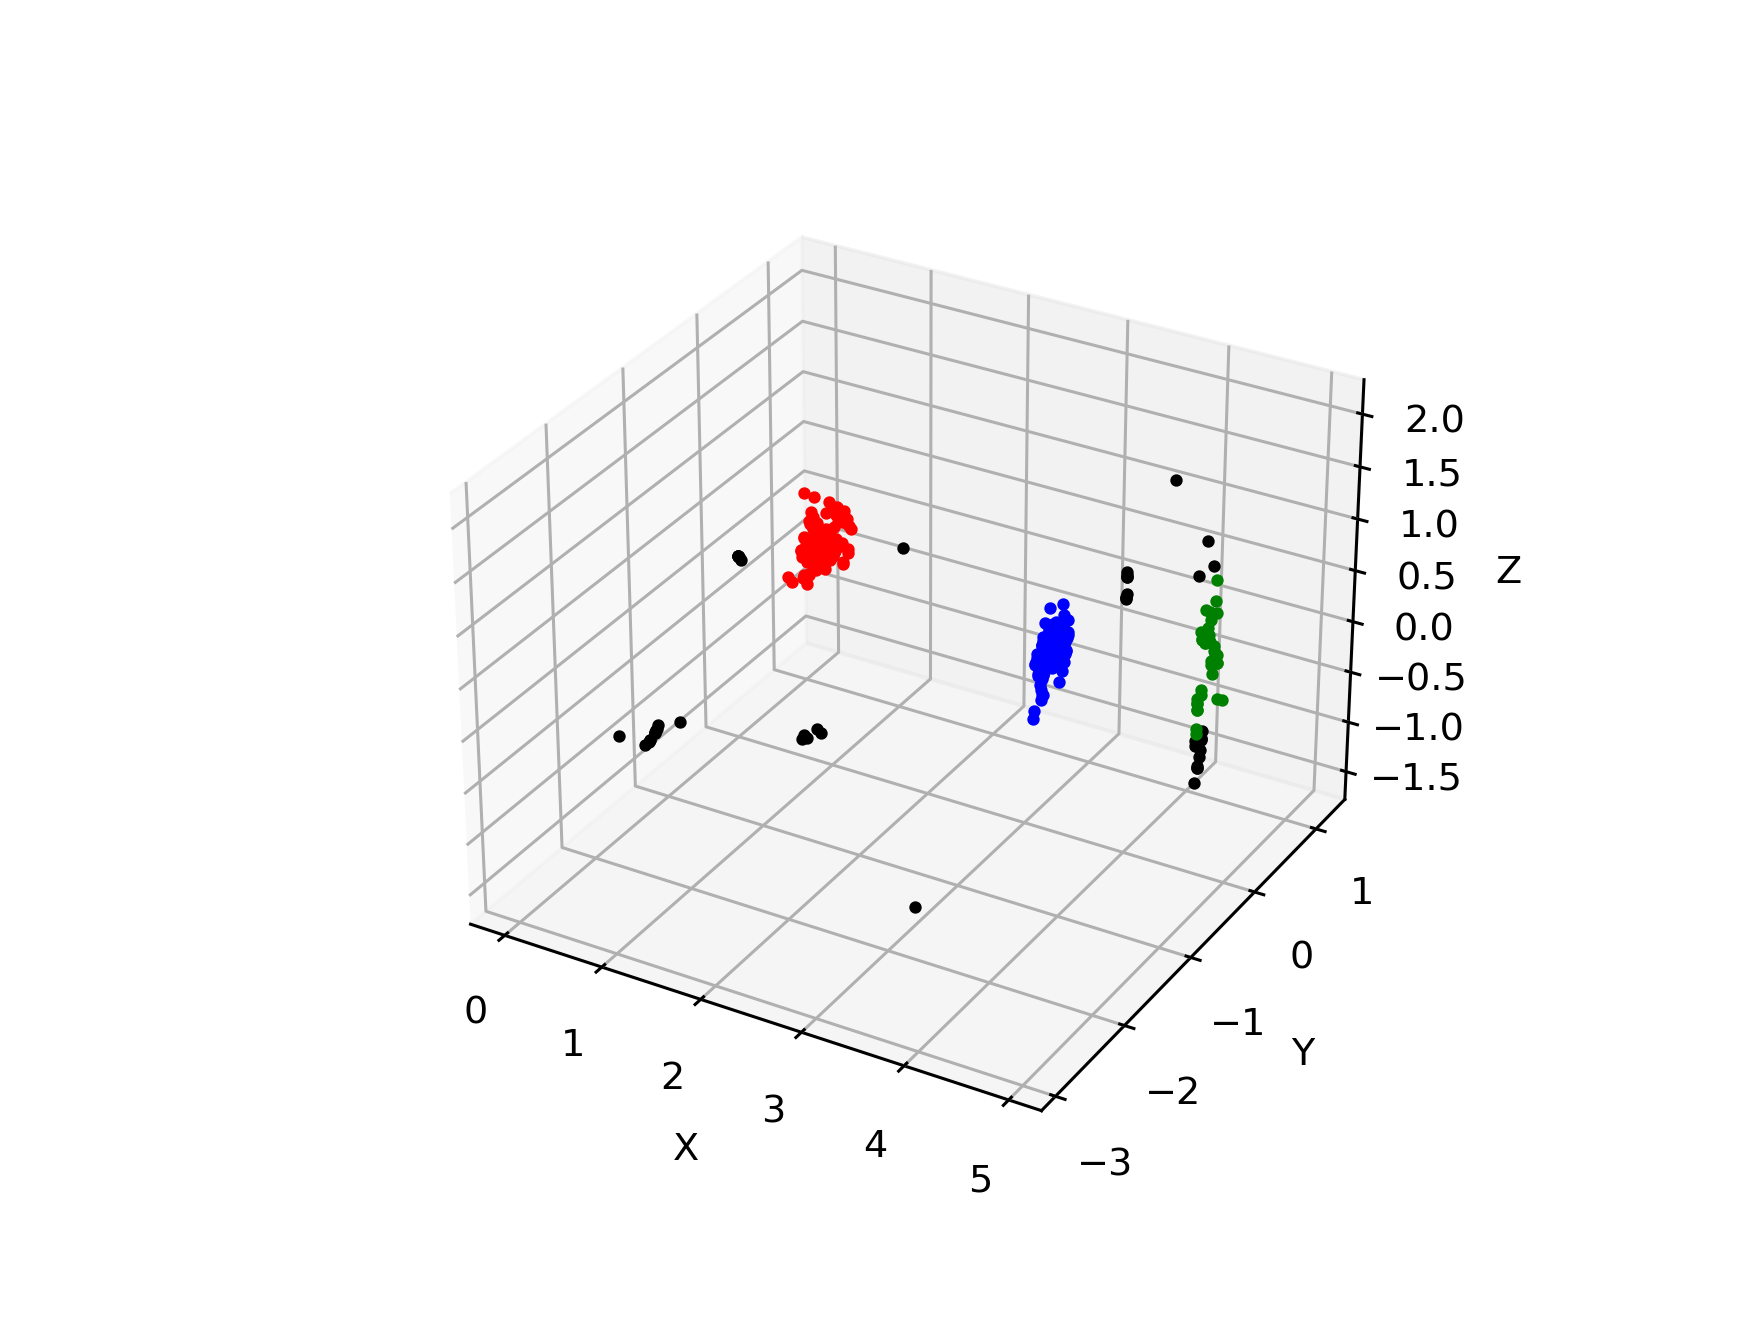

In [204]:
# Clustering frame_num = 10~14
startFrame = 10
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

ModelCluster(datalist, dbscan)
ModelCluster(datalist, dbscan, sample_weight=True)

<IPython.core.display.Javascript object>


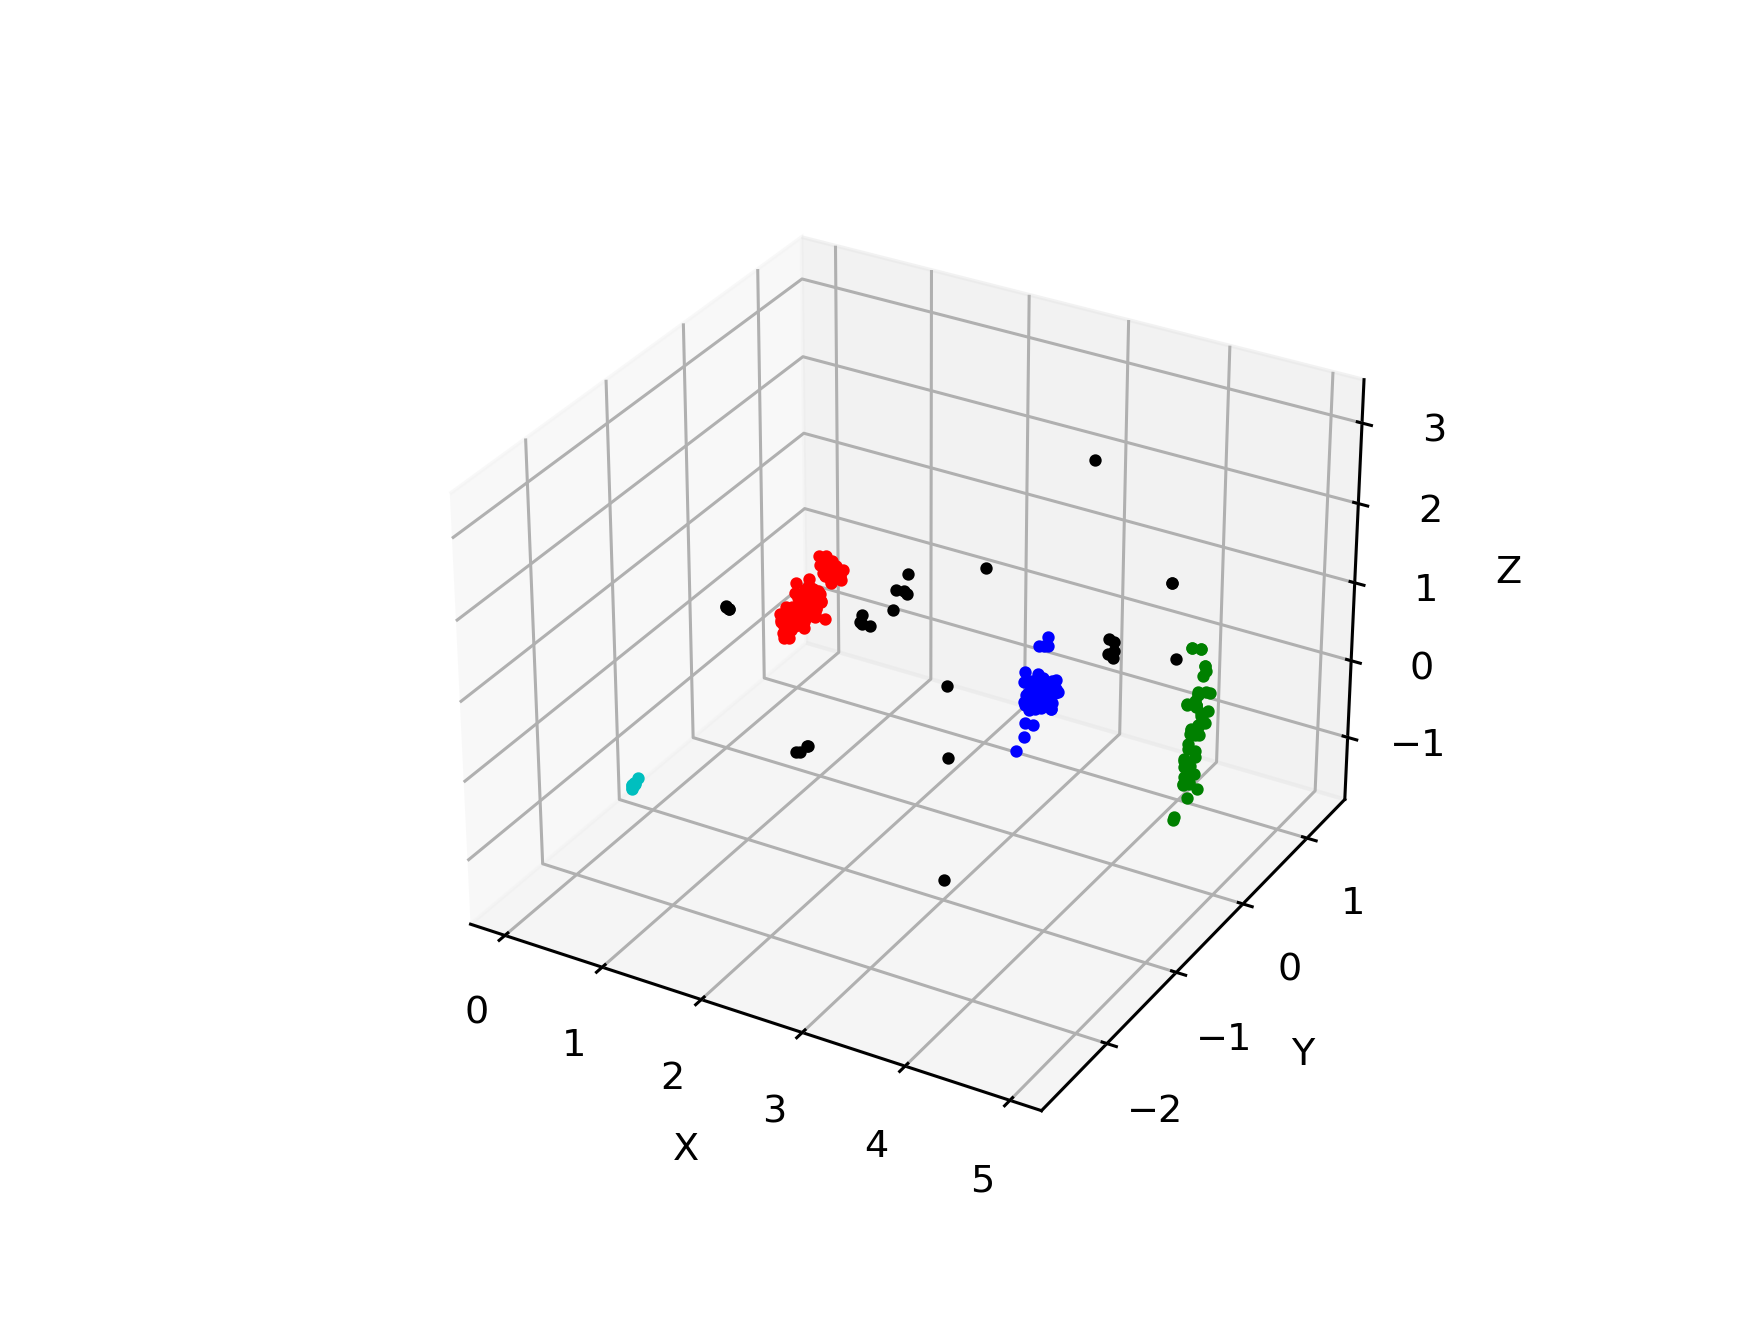

<IPython.core.display.Javascript object>


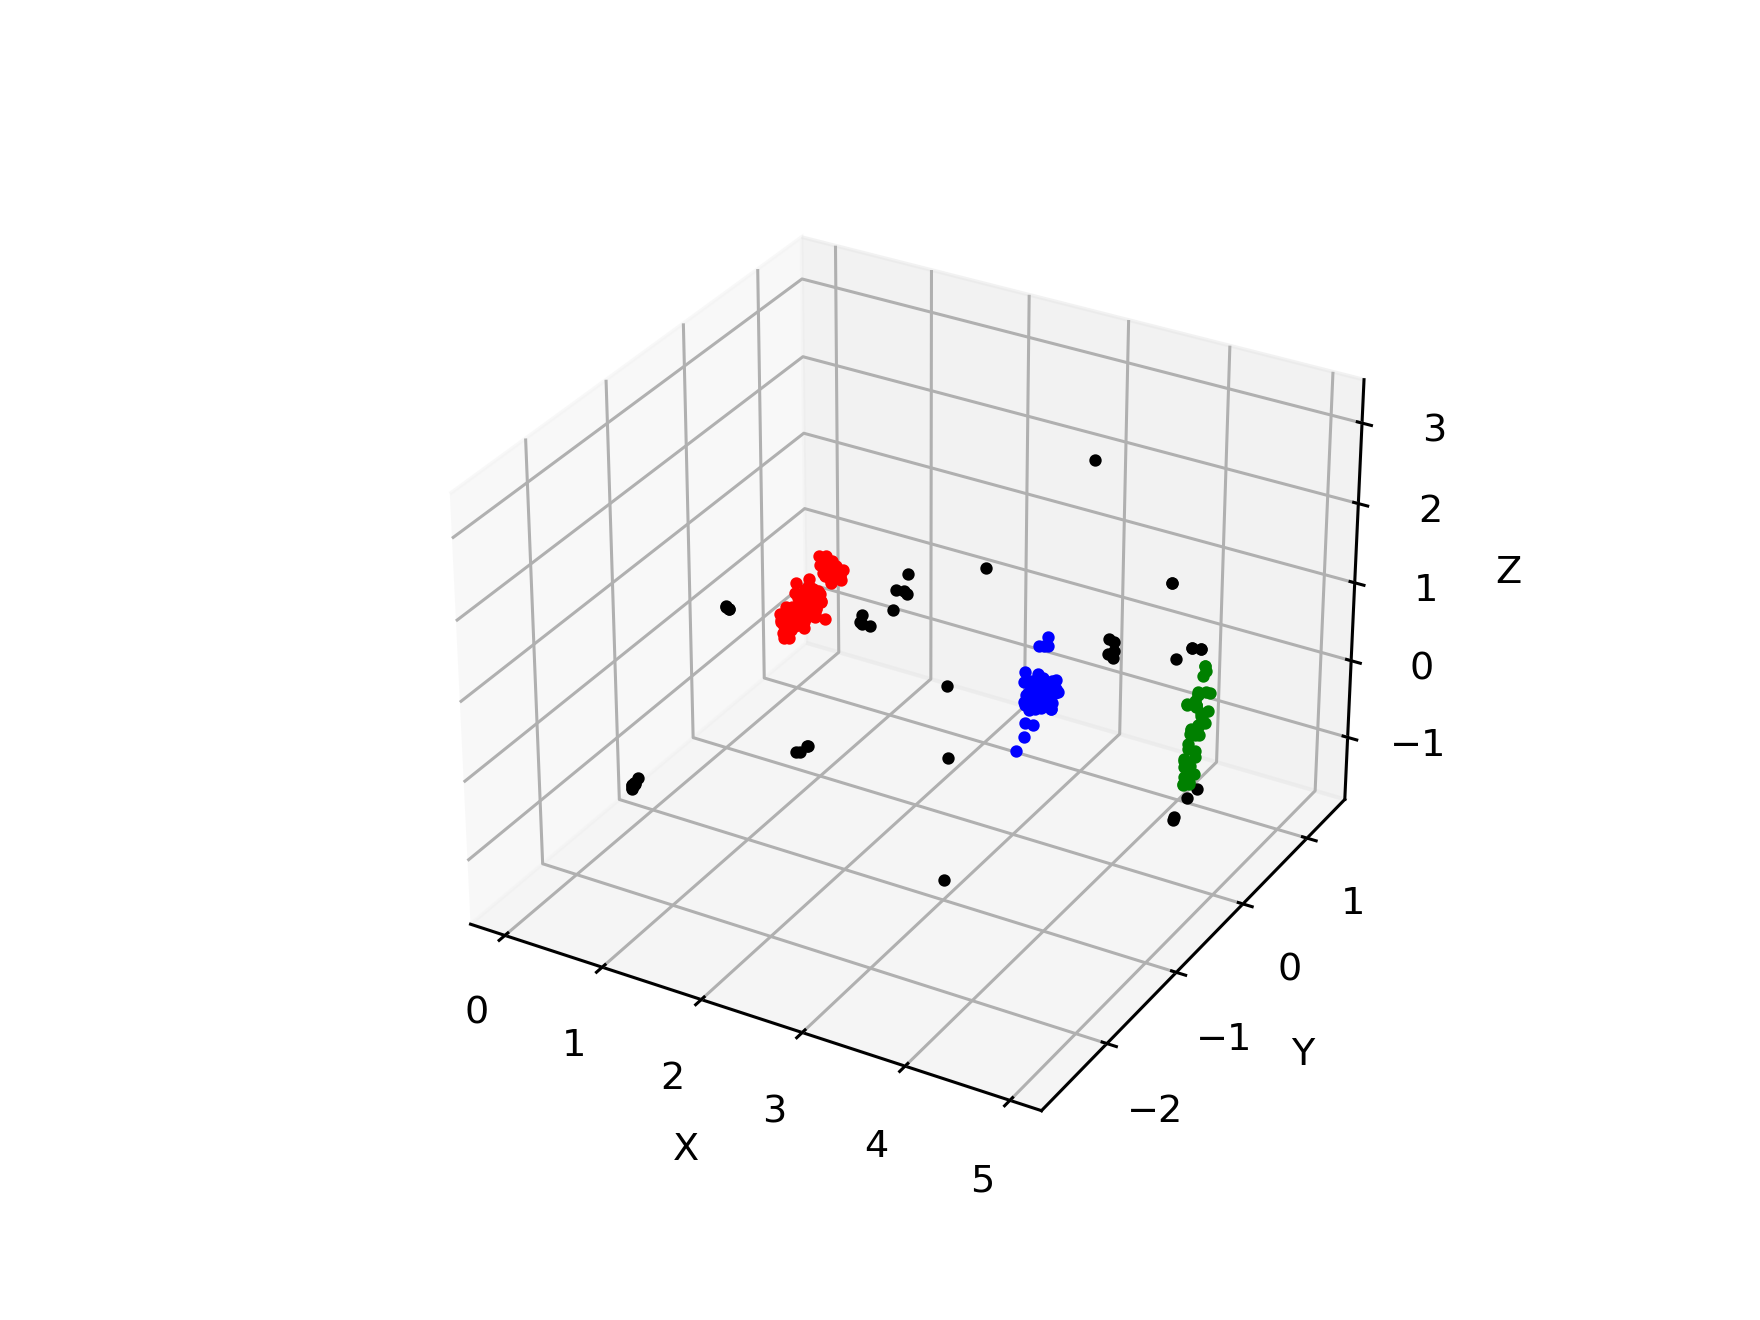

In [205]:
# Clustering frame_num = 15~19
startFrame = 15
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

ModelCluster(datalist, dbscan)
ModelCluster(datalist, dbscan, sample_weight=True)

## Change DBSCAN eps, min_samples [TODO]

# Draw boundary for each cluster

In [262]:
# Clustering frame_num = 0~4
startFrame = 0
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

clustering = ModelCluster(datalist, dbscan, sample_weight=True, show_plot=False, return_cluster=True)
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1, -1,
       -1,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1, -1,  2,  2,  2,  2, -1,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  2,  2,  2, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1, -1, -1,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1, -1,  2,  2,  2,  2, -1,  0,  0,  0, -1,  0,
        0,  0,  0,  1,  1,  1,  2,  2, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  2,  2,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1, -1,  2,
        2,  2,  2, -1,  0,  0,  0,  1,  1,  1,  2,  2, -1,  0,  0,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  1,  1,  1,  1,  1,  1,
       -1, -1,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  1,
        1,  1,  1,  1,  1, -1,  2,  2,  2,  2, -1,  0,  0,  0,  0,  0,  1,
        1,  1, -1,  2,  2

In [358]:
# Number of points in each cluster
def ClusterAnalysis(labels):
    print('Total:', len(labels), 'points,', len(np.unique(labels))-1, 'clusters')
    for i in range(np.max(np.unique(labels))+1):
        print('Cluster', i, ':', np.sum(labels==i), 'points')
    print('Noise:', np.sum(labels==-1), 'points')

In [359]:
ClusterAnalysis(clustering.labels_)

Total: 282 points, 3 clusters
Cluster 0 : 116 points
Cluster 1 : 79 points
Cluster 2 : 48 points
Noise: 39 points


In [360]:
# Weighted centroid position of current clustre
def ClusterCenter(clusterlist):
    return np.average(clusterlist[['x','y','z']], axis=0, weights=Weight(clusterlist))

In [387]:
# Weighted centroid position of 0-th cluster at 0-th timeStep

clusterlist = datalist[clustering.labels_==0]
cluster_center = ClusterCenter(clusterlist)
print(cluster_center)

[0.56687295 0.45225677 0.13095793]


In [731]:
# Find extension (l,w,h) with pre-assumption of normal distribution
def GaussianCovariance(clusterlist, cluster_center, cluster_pt_weight):
    cluster_cov = np.zeros(3)
    
    for idx in range(len(clusterlist.index)):
        cluster_cov[0] += cluster_pt_weight[idx]*np.dot(np.array(clusterlist.x)[idx]-cluster_center[0], np.array(clusterlist.x)[idx]-cluster_center[0])
        cluster_cov[1] += cluster_pt_weight[idx]*np.dot(np.array(clusterlist.y)[idx]-cluster_center[1], np.array(clusterlist.y)[idx]-cluster_center[1])
        cluster_cov[2] += cluster_pt_weight[idx]*np.dot(np.array(clusterlist.z)[idx]-cluster_center[2], np.array(clusterlist.z)[idx]-cluster_center[2])
    cluster_cov = cluster_cov/np.sum(cluster_pt_weight)
    return np.sqrt(cluster_cov)*6 # Gaussian 3-sigma rule
    

In [811]:
from scipy.optimize import linear_sum_assignment

# Shift (l,w,h) order in arbitrary orientations so they align (as close as possible) with 3 axes
def ShiftAxis(cluster_extension, cluster_orientation):
    shift_index = np.zeros((3,3))
    for axis in range(3):
        for idx in range(3):
            shift_index[axis, idx] = VectorAngle(cluster_orientation[idx], np.identity(3)[axis])
    shift_index = linear_sum_assignment(shift_index, maximize=True)[1] # Hungarian Algorithm, column index
    
    cluster_orientation = cluster_orientation[shift_index]
    cluster_extension = cluster_extension[shift_index]
    
    for idx in range(3):
        if np.dot(cluster_orientation[idx], np.identity(3)[idx])<0:
            cluster_orientation[idx] = -cluster_orientation[idx]
    
    return cluster_extension, cluster_orientation

In [865]:
# Estimate extension of the cluster
def ClusterExtension(clusterlist, orientation = True):
    cluster_pt_weight = Weight(clusterlist)
    cluster_center = ClusterCenter(clusterlist)

    if orientation:
        # Covariance of centroid position
        cluster_cov = np.zeros((3,3))
        for i in range(len(clusterlist)):
            cluster_cov += cluster_pt_weight[i]*np.dot(HorToVer(np.array(clusterlist[['x','y','z']])[i]-cluster_center), VerToHor(np.array(clusterlist[['x','y','z']])[i]-cluster_center))
        cluster_cov = cluster_cov/np.sum(cluster_pt_weight)

        # cluster_npcov = np.cov(np.array(clusterlist[['x','y','z']]), rowvar=False, aweights=cluster_pt_weight) # Or use default weighted cov function from numpy (slightly difference in extension, same in orientation)
        cluster_extension, cluster_orientation = np.linalg.eig(cluster_cov) # Use eigenvalue, eigenvector for estimating extension, orientation
        cluster_extension = np.sqrt(cluster_extension)*6 # Gaussian 3-sigma rule
        cluster_orientation = cluster_orientation.T
        
        cluster_extension, cluster_orientation = ShiftAxis(cluster_extension, cluster_orientation)

    else:
        # Orientation set default to along axes
        ## Method 1: box constraint
        # cluster_extension = np.array([np.max(clusterlist.x) - np.min(clusterlist.x), np.max(clusterlist.y) - np.min(clusterlist.y), np.max(clusterlist.z) - np.min(clusterlist.z)])
        
        ## Method 2: assume points in each axis is normal distribution
        cluster_extension = GaussianCovariance(clusterlist, cluster_center, cluster_pt_weight)
        cluster_orientation = np.identity(3)

    return cluster_extension, cluster_orientation

In [810]:
# Esimate extension of 0-th cluster at 0-th timeStep

# With orientation
cluster_extension, cluster_orientation = ClusterExtension(clusterlist)
print('With orientation estimation:')
print('length:', cluster_extension[0])
print('width:', cluster_extension[1])
print('height:', cluster_extension[2])
print('orientation:', cluster_orientation[np.argmax(cluster_extension)])

# Without orientation
cluster_extension, cluster_orientation = ClusterExtension(clusterlist, orientation=False)
print('\nWithout orientation estimation:')
print('length:', cluster_extension[0])
print('width:', cluster_extension[1])
print('height:', cluster_extension[2])
print('orientation:', cluster_orientation[np.argmax(cluster_extension)])

With orientation estimation:
length: 0.4288421062385612
width: 0.27894703490323325
height: 1.3922257818396462
orientation: [0.21840873 0.1774787  0.95958269]

Without orientation estimation:
length: 0.4618542197069611
width: 0.425554289812297
height: 1.330748432248082
orientation: [0. 0. 1.]


In [589]:
# ref: http://kylebarbary.com/nestle/examples/plot_ellipsoids.html

# Plot the 3-d Ellipsoid on the Axes3D ax.
def PlotEllipsoid(ax, center, orientation, color='dodgerblue', npoints=100):
    # Set points on unit sphere
    u = np.linspace(0.0, 2.0 * np.pi, npoints)
    v = np.linspace(0.0, np.pi, npoints)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Transform points to ellipsoid
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j], y[i,j], z[i,j] = center + np.dot(orientation, [x[i,j], y[i,j], z[i,j]])

    ax.plot_wireframe(x, y, z,  rstride=10, cstride=10, color=color, alpha=0.2, linewidth=1)


In [547]:
def PlotArrow(ax, center, orientation, extension=np.ones(3)/2):
    # center: array 1x3
    # orientation: matrix 3x3
    # extension: array 1x3
    ax.quiver(center[0], center[1], center[2], orientation[0][0], orientation[0][1], orientation[0][2], length=extension[0], color='tab:blue', normalize=True)
    ax.quiver(center[0], center[1], center[2], orientation[1][0], orientation[1][1], orientation[1][2], length=extension[1], color='tab:orange', normalize=True)
    ax.quiver(center[0], center[1], center[2], orientation[2][0], orientation[2][1], orientation[2][2], length=extension[2], color='tab:green', normalize=True)


In [818]:
def PlotClusterEllipsoid(ax, clusterlist, orientation=True,  plot_arrow=True, color='dodgerblue'):
    cluster_center = ClusterCenter(clusterlist)
    cluster_extension, cluster_orientation = ClusterExtension(clusterlist, orientation=orientation)
    print('Center=', cluster_center, '\tL=', cluster_extension[0], '\tW=', cluster_extension[1], '\tH=', cluster_extension[2], '\tDirection=', cluster_orientation[np.argmax(cluster_extension)])

    # Plot center
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], color='r', marker='.')

    # Plot ellipsoid
    PlotEllipsoid(ax, cluster_center, (cluster_orientation * HorToVer(cluster_extension)/2).T, color=color)
    
    # Plot orientation arrow
    if plot_arrow:
        PlotArrow(ax, cluster_center, cluster_orientation, cluster_extension/2)
        

<IPython.core.display.Javascript object>


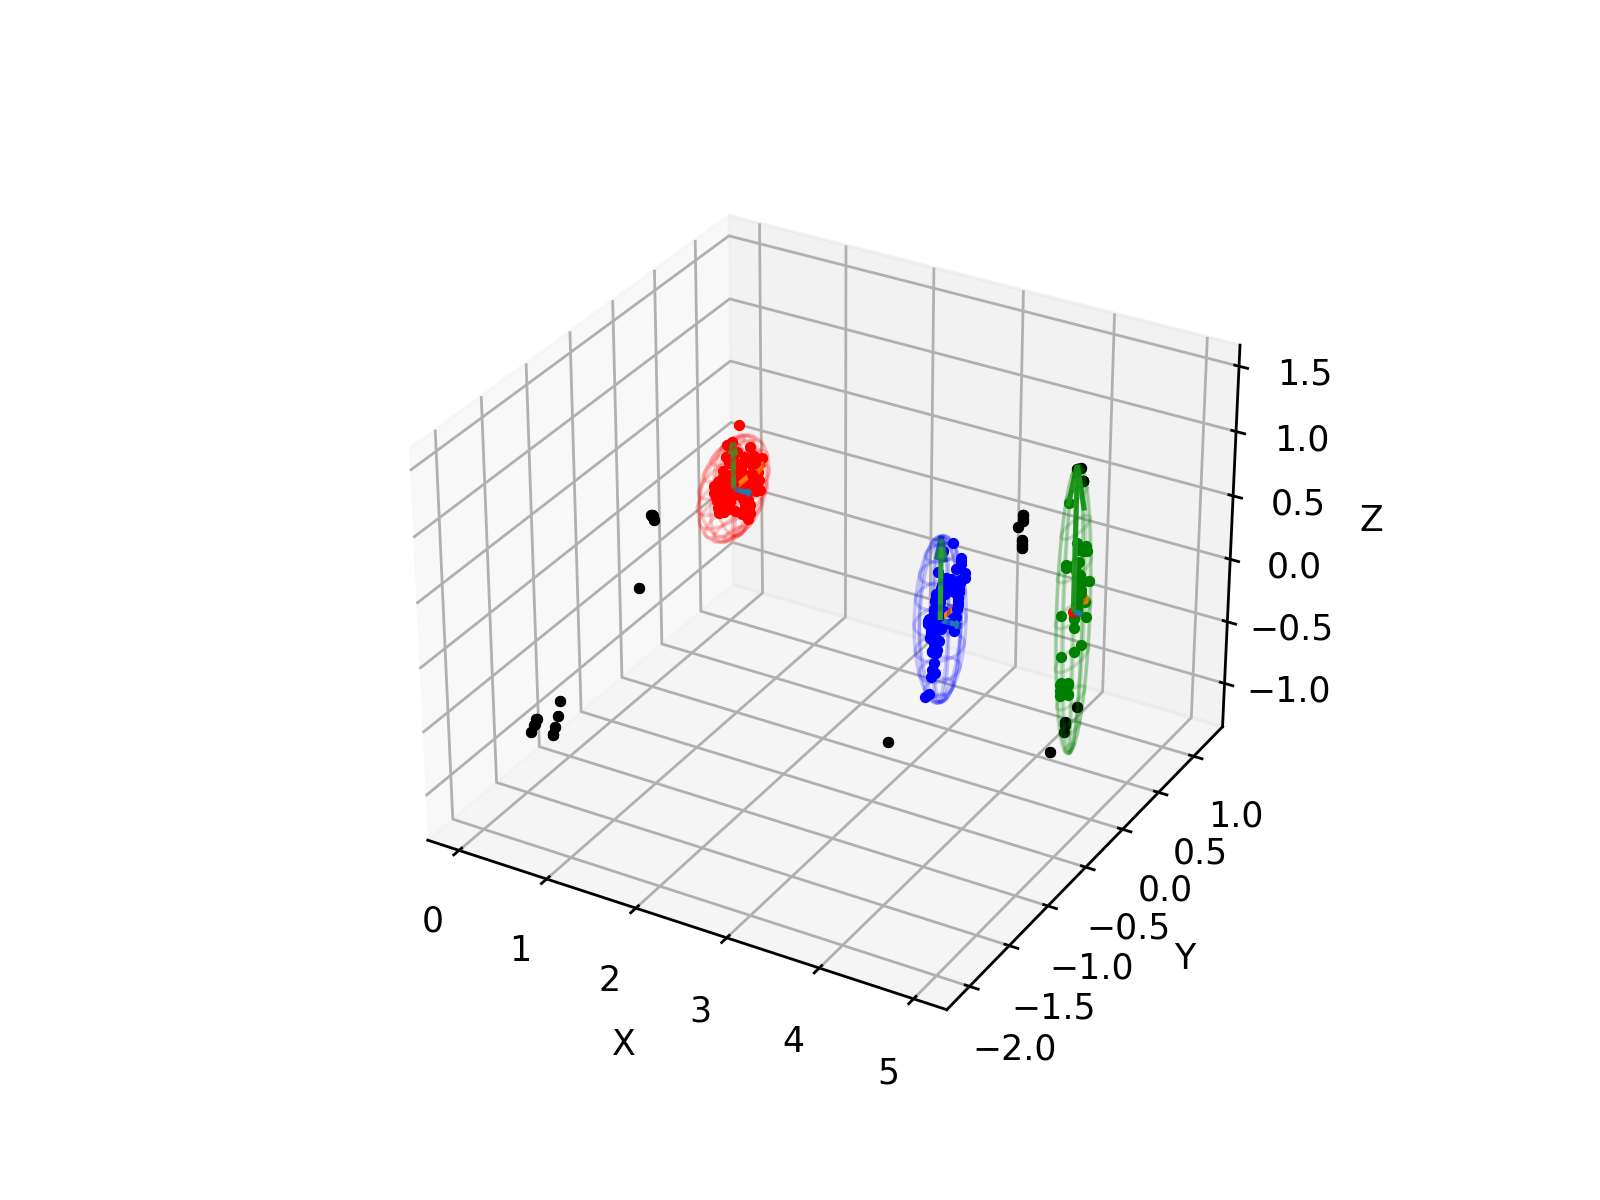

Center= [0.56687295 0.45225677 0.13095793] 	L= 0.4282238543972365 	W= 0.7821356392089456 	H= 0.7613604312948521 	Direction= [0. 1. 0.]
Center= [ 2.88128528  0.51303842 -0.49494222] 	L= 0.4618542197069611 	W= 0.425554289812297 	H= 1.330748432248082 	Direction= [0. 0. 1.]
Center= [ 4.88946754 -0.17889106  0.36376165] 	L= 0.19055439718205736 	W= 0.4081591967203814 	H= 2.208091211067745 	Direction= [0. 0. 1.]


In [765]:
# Estimate extension of all clusters at 0-th timeStep (default orientation on axes)

fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

PlotData(ax, datalist, color=GetColors(clustering.labels_))

for i in range(np.max(np.unique(clustering.labels_))+1):
    PlotClusterEllipsoid(ax, datalist[clustering.labels_==i], orientation=False, plot_arrow=True, color=GetColors([i]))
PlotData(ax, datalist[clustering.labels_==-1], color='k')

plt.show()

<IPython.core.display.Javascript object>


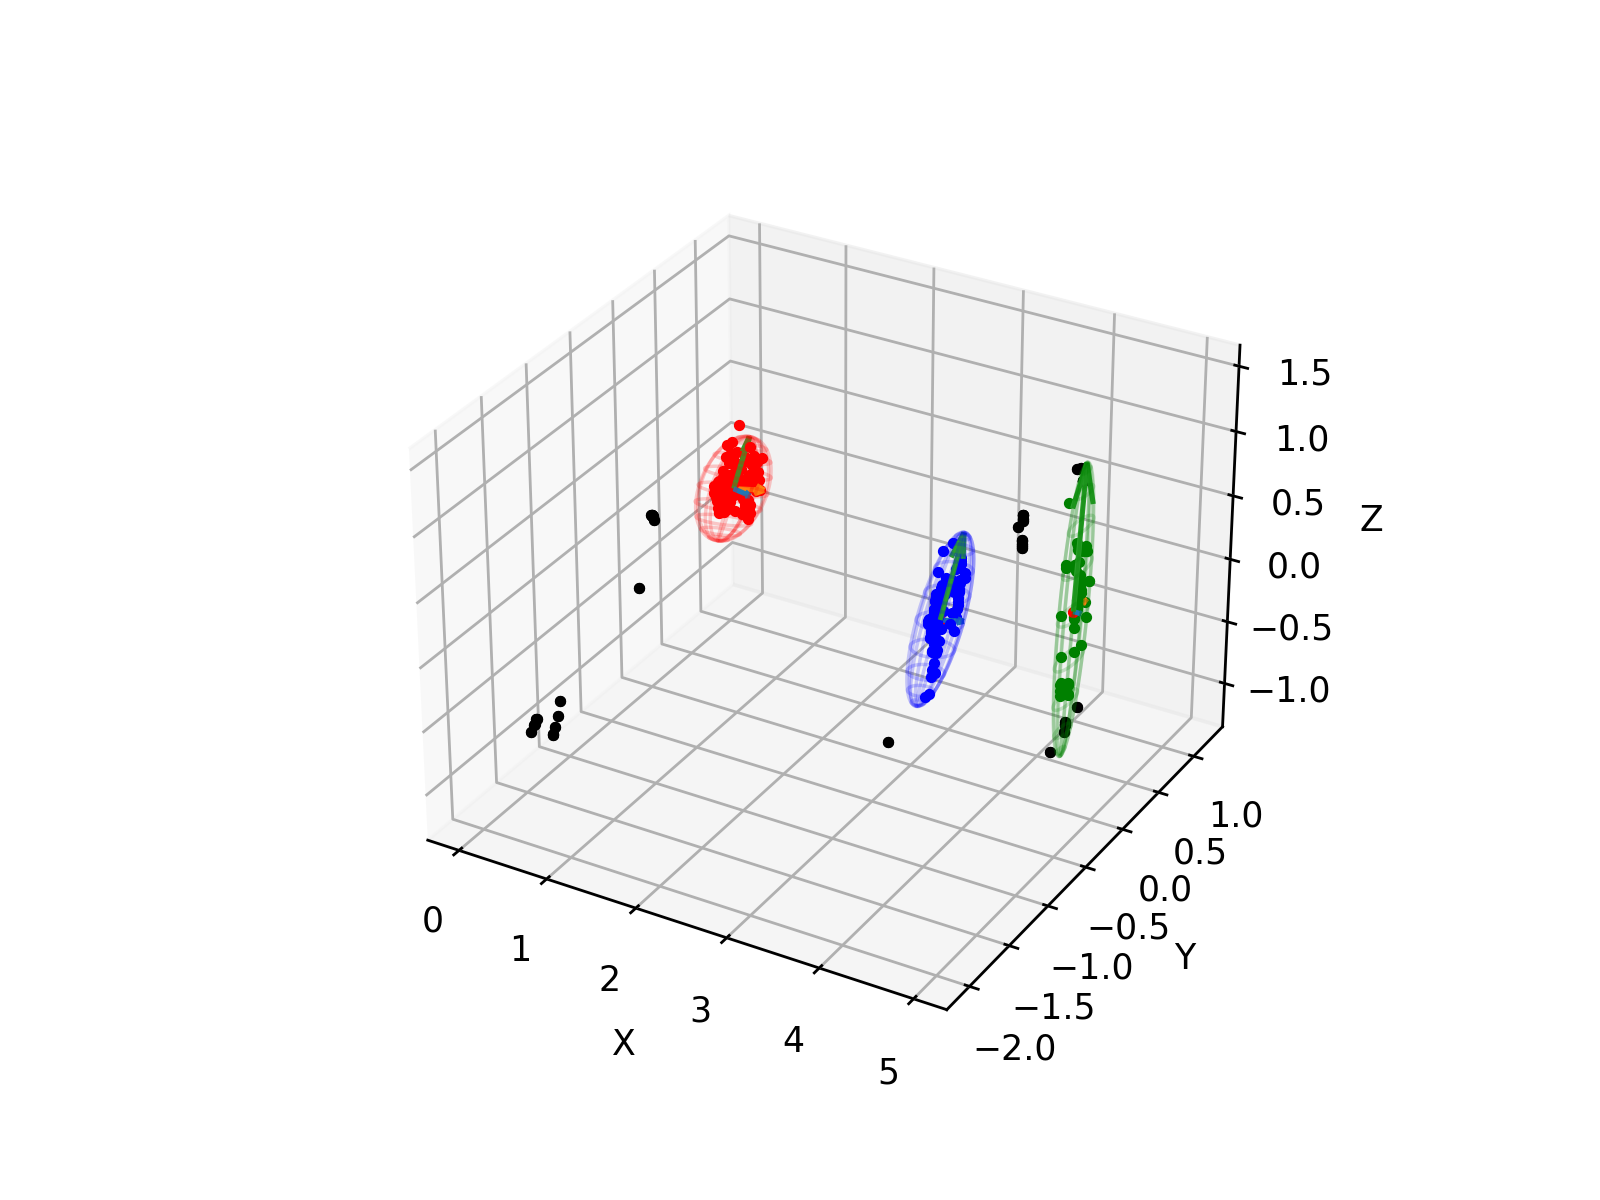

Center= [0.56687295 0.45225677 0.13095793] 	L= 0.422100435303007 	W= 0.7945291928128605 	H= 0.7518883681918821 	Direction= [ 0.08439314  0.87876826 -0.46972773]
Center= [ 2.88128528  0.51303842 -0.49494222] 	L= 0.4254454497802436 	W= 0.27673762674613045 	H= 1.3811986167722983 	Direction= [0.21840873 0.1774787  0.95958269]
Center= [ 4.88946754 -0.17889106  0.36376165] 	L= 0.15848996012872352 	W= 0.39165227668122804 	H= 2.2136081702180888 	Direction= [0.04673154 0.05373684 0.99746103]


In [866]:
# Estimate extension of all clusters at 0-th timeStep (arbitrary orientation)

fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

PlotData(ax, datalist, color=GetColors(clustering.labels_))

for i in range(np.max(np.unique(clustering.labels_))+1):
    PlotClusterEllipsoid(ax, datalist[clustering.labels_==i], orientation=True, plot_arrow=True, color=GetColors([i]))
PlotData(ax, datalist[clustering.labels_==-1], color='k')

plt.show()

# Cluster-based Observation state Z(k, n)

In [ ]:
# Combine observation estimations (cluster_center, cluster_extension, cluster_orientation) together


# Tracks

In [647]:
#### TODO: tracklist in format of dataframe
tracklist = []

for startFrame in range(600):
    dbscan = DBSCAN(eps=0.4, min_samples=10)
    datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

    clustering = ModelCluster(datalist, dbscan, sample_weight=True, show_plot=False, return_cluster=True)

    # Find center of each cluster
    cluster_centers = []
    for i in range(np.max(np.unique(clustering.labels_))+1):
        cluster_centers.append(ClusterCenter(datalist[clustering.labels_==i]))
    tracklist.append(cluster_centers)
    

<IPython.core.display.Javascript object>


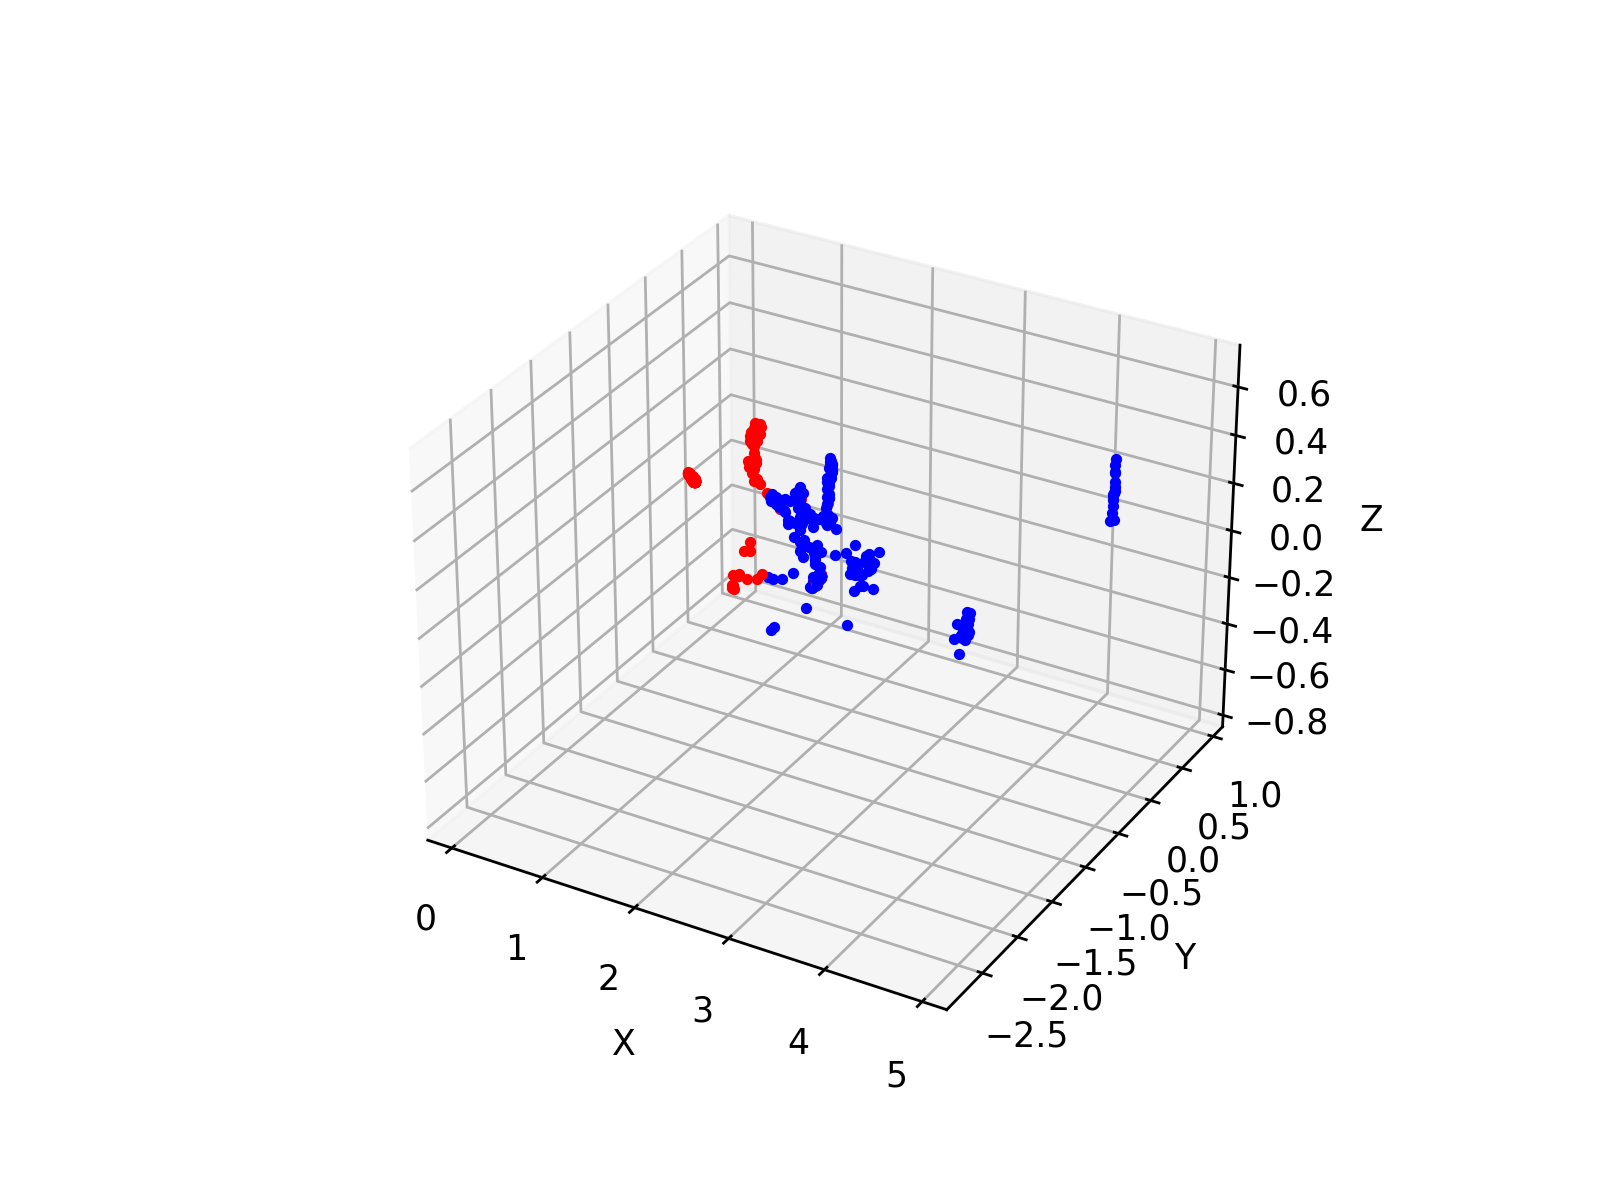